# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r"C:\Users\prane\Downloads\malicious_phish.csv")

In [3]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## 1.1 checking for null values and duplicate values

In [4]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [5]:
# Checking any duplicated values are present
dup=data.duplicated().value_counts()
dup

False    641125
True      10066
dtype: int64

##### There  are no null values present in data set but 10066 duplicate values are there, now we are gonna drop the duplicate values

In [6]:

data = data.drop_duplicates()

In [7]:
data.shape

(641125, 2)

##### The data was sampled, capturing only 50% of the original dataset due to its excessive size, making a comprehensive analysis more efficient.

In [8]:
data = data.sample(frac=0.50,random_state=42)


##### To breakdown the URLS will be using RegexTokenizer

In [9]:
from nltk.tokenize import RegexpTokenizer  

tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [10]:
data['tokenized_text'] = data.url.map(lambda i: tokenizer.tokenize(i))

In [11]:
data.head()

,url,type,tokenized_text
273363,calstatela.edu/univ/ppa/publicat/today/sportsF...,benign,"[calstatela, edu, univ, ppa, publicat, today, ..."
165953,https://myspace.com/article/2015/5/13/wait-doe...,benign,"[https, myspace, com, article, wait, does, sno..."
433977,blockbuster.com/browse/catalog/movieDetails/52...,benign,"[blockbuster, com, browse, catalog, movieDetails]"
407055,http://udn.com/news/story/7002/894610-%E7%BE%8...,benign,"[http, udn, com, news, story, E, BE, E, AF, E,..."
113133,youtube.com/watch?v=P3FpARW-5nQ,benign,"[youtube, com, watch, v, P, FpARW, nQ]"


##### Using Snowball Stemmer as a stemming algorithm to convert tokenized words into their root form

In [12]:
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer(language='english')

In [13]:
st=lambda l: [snowball.stem(word) for word in l]
data['stemmed_words'] = data['tokenized_text'].map(st)

In [14]:
data['text_sentance'] = data['stemmed_words'].apply(lambda l: ' '.join(l))
data.head()

,url,type,tokenized_text,stemmed_words,text_sentance
273363,calstatela.edu/univ/ppa/publicat/today/sportsF...,benign,"[calstatela, edu, univ, ppa, publicat, today, ...","[calstatela, edu, univ, ppa, publicat, today, ...",calstatela edu univ ppa publicat today sportsf...
165953,https://myspace.com/article/2015/5/13/wait-doe...,benign,"[https, myspace, com, article, wait, does, sno...","[https, myspac, com, articl, wait, doe, snoop,...",https myspac com articl wait doe snoop dogg th...
433977,blockbuster.com/browse/catalog/movieDetails/52...,benign,"[blockbuster, com, browse, catalog, movieDetails]","[blockbust, com, brows, catalog, moviedetail]",blockbust com brows catalog moviedetail
407055,http://udn.com/news/story/7002/894610-%E7%BE%8...,benign,"[http, udn, com, news, story, E, BE, E, AF, E,...","[http, udn, com, news, stori, e, be, e, af, e,...",http udn com news stori e be e af e bc b e b e...
113133,youtube.com/watch?v=P3FpARW-5nQ,benign,"[youtube, com, watch, v, P, FpARW, nQ]","[youtub, com, watch, v, p, fparw, nq]",youtub com watch v p fparw nq


##### We need to convert the text into sparse matrix for preporming ML models for that will be using TfidfVectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [16]:
x= tfidf.fit_transform(data["text_sentance"])
y=data.type

In [17]:
data['text_sentance'][0]

'br icloud com br'

Plot token frequency distribution across the x dataset


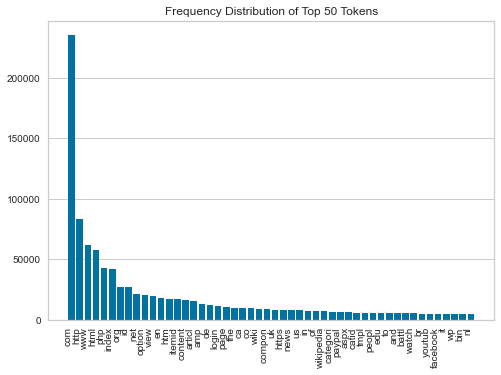

In [19]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

cv = CountVectorizer()
x = cv.fit_transform(data.text_sentance)
y = data.type

print("Plot token frequency distribution across the x dataset")
features_tokens = cv.get_feature_names_out()
n_top_tokens = 50
plt.clf()
token_visualizer = FreqDistVisualizer(features=features_tokens, orient='v', n=n_top_tokens)
token_visualizer.fit(x)
token_visualizer.set_title(f"Frequency Distribution of Top " + str(n_top_tokens) + " Tokens")

In [20]:
value_counts = data['type'].value_counts()
print(value_counts)

benign        214234
defacement     47611
phishing       47037
malware        11680
Name: type, dtype: int64


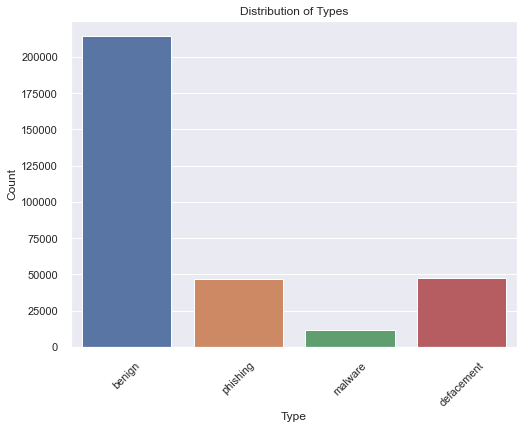

In [21]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of Types')
plt.xticks(rotation=45)

plt.show()

### Splitting the dataset for Training and Testing

In [22]:
from sklearn.model_selection import train_test_split
split_ratio = 0.30
random_state = 42 
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=split_ratio, random_state=random_state)


##### Applying random oversampling to the training data only for the classes with fewer samples, in order to achieve a balanced representation of all classes with an equal number of samples

In [23]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)

In [24]:
X_train,Y_train=ros.fit_resample(X_train,Y_train)

In [25]:

unique_values, counts = np.unique(Y_train, return_counts=True)
result = dict(zip(unique_values, counts))
print(result)

{'benign': 150066, 'defacement': 150066, 'malware': 150066, 'phishing': 150066}


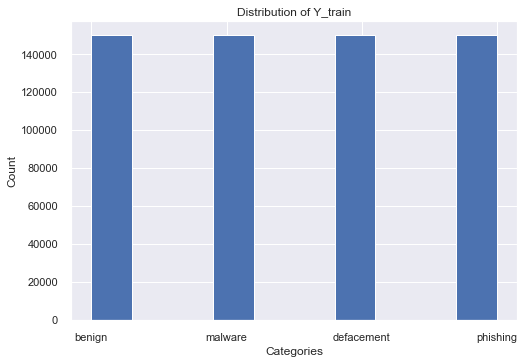

In [26]:
plt.hist(Y_train)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Y_train')
plt.show()

# 2. ML Models

### 2.1 Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')

In [28]:
lr.fit(X_train,Y_train)

LogisticRegression(solver='liblinear')

Training Accuracy: 0.9920851492010182
Testing Accuracy: 0.9425074608241741

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.96      0.96      0.96     64168
  defacement       0.99      1.00      0.99     14353
     malware       0.93      0.95      0.94      3511
    phishing       0.82      0.79      0.81     14137

    accuracy                           0.94     96169
   macro avg       0.92      0.93      0.93     96169
weighted avg       0.94      0.94      0.94     96169


CONFUSION MATRIX


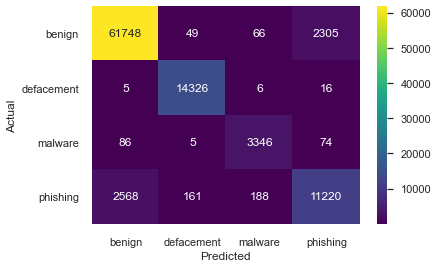

In [29]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train_accuracy = accuracy_score(Y_train, lr.predict(X_train))
test_accuracy = accuracy_score(Y_test, lr.predict(X_test))
print('Training Accuracy:', train_accuracy)
print('Testing Accuracy:', test_accuracy)
pred_lr = lr.predict(X_test)
con_m = pd.crosstab(Y_test, pred_lr, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(Y_test, pred_lr))
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap="viridis")
plt.show()


In [100]:
from sklearn.metrics import f1_score
f1_score_lr = f1_score(Y_test, pred_lr, average='macro', labels=np.unique(pred_lr))
print('F1 Score: {:.2f}'.format(f1_score_lr))
Score = dict()
Score['LR'] = round(f1_score_lr, 2)


F1 Score: 0.93


## 2.2 Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=10)


In [37]:
decision_tree.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=10)

Training Accuracy: 0.8509722388815588
Testing Accuracy: 0.8507315247117054

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.86      0.95      0.90     58286
  defacement       0.98      0.76      0.86     18541
     malware       0.89      0.71      0.79      4417
    phishing       0.67      0.63      0.65     14925

    accuracy                           0.85     96169
   macro avg       0.85      0.76      0.80     96169
weighted avg       0.85      0.85      0.85     96169


CONFUSION MATRIX


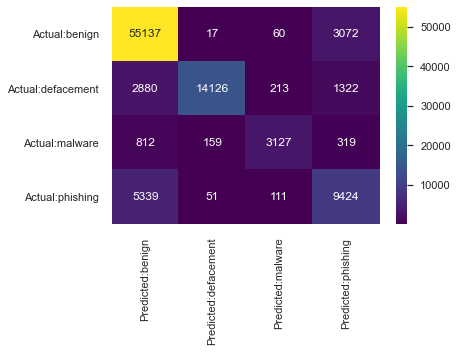

In [38]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
training_accuracy = accuracy_score(Y_train, decision_tree.predict(X_train))
testing_accuracy = accuracy_score(Y_test, decision_tree.predict(X_test))
print('Training Accuracy:', training_accuracy)
print('Testing Accuracy:', testing_accuracy)
pred_dt = decision_tree.predict(X_test)
con_m = pd.crosstab(Y_test, pred_dt, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(pred_dt, Y_test))
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap="viridis")
plt.show()


In [102]:
from sklearn.metrics import f1_score
unique_labels = np.unique(pred_dt)
f1_score_dt = f1_score(Y_test, pred_dt, average='macro', labels=unique_labels)
rounded_f1_score_dt = np.round(f1_score_dt, 2)
Scores_ml['DT'] = rounded_f1_score_dt
print(rounded_f1_score_dt)


0.8


## 2.3 SVM

In [41]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel="rbf", C=1, probability=True)



In [ ]:
svm_classifier.fit(X_train,Y_train)

Training Accuracy: 0.9954353417829488
Testing Accuracy: 0.9528850253200095

CONFUSION MATRIX

                   Predicted:benign  Predicted:defacement  Predicted:malware  \
Actual:benign                 62608                     9                  4   
Actual:defacement                60                 14269                  1   
Actual:malware                   89                    13               3283   
Actual:phishing                2468                   143                 48   

                   Predicted:phishing  
Actual:benign                    1547  
Actual:defacement                  23  
Actual:malware                    126  
Actual:phishing                 11478  

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     64168
  defacement       0.99      0.99      0.99     14353
     malware       0.98      0.94      0.96      3511
    phishing       0.87      0.81      0.84     14137

    accur

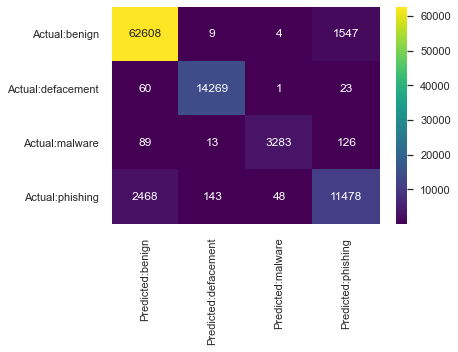

In [45]:
pred_sv = svm_classifier.predict(X_test)
training_accuracy = accuracy_score(Y_train, svm_classifier.predict(X_train))
testing_accuracy = accuracy_score(Y_test, pred_sv)
print('Training Accuracy:', training_accuracy)
print('Testing Accuracy:', testing_accuracy)
con_m = pd.crosstab(Y_test, pred_sv, rownames=['Actual'], colnames=['Predicted'])
print('\nCONFUSION MATRIX\n')
print('\nCLASSIFICATION REPORT\n')
print(classification_report(Y_test, pred_sv))
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap='viridis')
plt.show()


In [103]:
from sklearn.metrics import f1_score
unique_labels = np.unique(pred_sv)
f1_score_sv = f1_score(Y_test, pred_sv, average='macro', labels=unique_labels)
rounded_f1_score_sv = np.round(f1_score_sv, 2)
Scores_ml['SVM'] = rounded_f1_score_sv
print(rounded_f1_score_sv)

0.94


## 2.4 Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier  
Random_classi= RandomForestClassifier(n_estimators= 100, criterion="entropy")  

In [107]:
Random_classi.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy')

Training Accuracy: 0.9997967560939853
Testing Accuracy: 0.9138807723902713

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.97      0.92      0.95     64168
  defacement       0.98      1.00      0.99     14353
     malware       0.40      0.95      0.56      3511
    phishing       0.89      0.79      0.84     14137

    accuracy                           0.91     96169
   macro avg       0.81      0.91      0.83     96169
weighted avg       0.94      0.91      0.92     96169


CONFUSION MATRIX


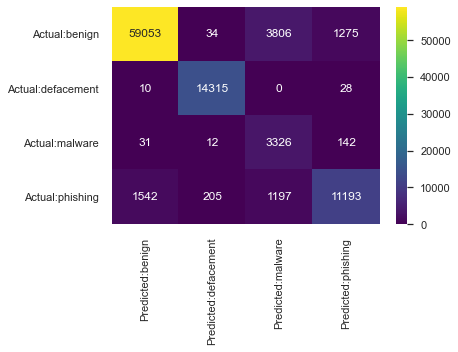

In [108]:
training_accuracy = accuracy_score(Y_train, Random_classi.predict(X_train))
testing_accuracy = accuracy_score(Y_test, Random_classi.predict(X_test))
print('Training Accuracy:', training_accuracy)
print('Testing Accuracy:', testing_accuracy)
pred_rf=Random_classi.predict(X_test)
con_m = pd.crosstab(Y_test, pred_rf, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(Y_test, pred_rf))
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap='viridis')
plt.show()


In [109]:
from sklearn.metrics import f1_score
unique_labels = np.unique(pred_rf)
f1_score_rf = f1_score(Y_test, pred_rf, average='macro', labels=unique_labels)
rounded_f1_score_rf = np.round(f1_score_rf, 2)
Scores_ml['RF'] = rounded_f1_score_rf
print(rounded_f1_score_rf)

0.83


In [182]:
F1_scores

{'LR': 0.93, 'DT': 0.8, 'SVM': 0.94, 'RF': 0.83, 'XGB': 0.94}

### 2.5 XGB

In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000,objective='binary:logistic',learning_rate=0.5,max_depth=10)

In [28]:
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
data1=asarray(Y_train)
data2=asarray(Y_test)

encoder = OrdinalEncoder()
Y_train1 = encoder.fit_transform(data1.reshape(-1, 1))
Y_test1 = encoder.fit_transform(data2.reshape(-1, 1))
Y_train1

array([[0.],
       [2.],
       [0.],
       ...,
       [3.],
       [3.],
       [3.]])

In [29]:
xgb.fit(X_train,Y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Training Accuracy : 0.9898344728319539
Testing Accuracy : 0.9516164252513803

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     64262
           1       1.00      0.99      0.99     14457
           2       0.95      0.98      0.96      3413
           3       0.84      0.84      0.84     14037

    accuracy                           0.95     96169
   macro avg       0.94      0.94      0.94     96169
weighted avg       0.95      0.95      0.95     96169


CONFUSION MATRIX


<AxesSubplot:>

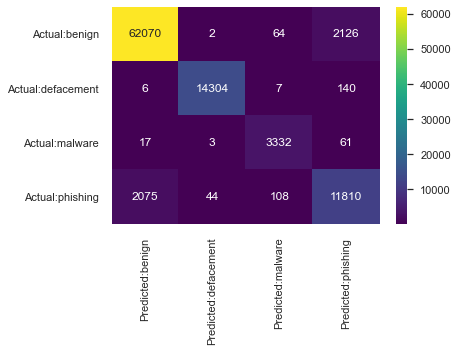

In [178]:
training_accuracy = accuracy_score(Y_train1, xgb.predict(X_train))
testing_accuracy = accuracy_score(Y_test1, xgb.predict(X_test))
print('Training Accuracy :',training_accuracy)
print('Testing Accuracy :',testing_accuracy)
pred_xgb=xgb.predict(X_test)
con_m = pd.crosstab(Y_test1, pred_xgb, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(pred_xgb, Y_test1))
print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_m, annot = True,fmt='d',cmap="viridis",)

In [179]:
f1_score_xgb = f1_score(Y_test1, pred_xgb, average='macro', labels=np.unique(pred_xgb))
print(f1_score_xgb)
Score['XGB'] = np.round(f1_score_xgb,2)

0.9400990491012661


In [180]:
Score

{'LR': 0.93, 'DT': 0.8, 'SVM': 0.94, 'RF': 0.83, 'XGB': 0.94}

### 2.6 Comparision of Accuracy of Models

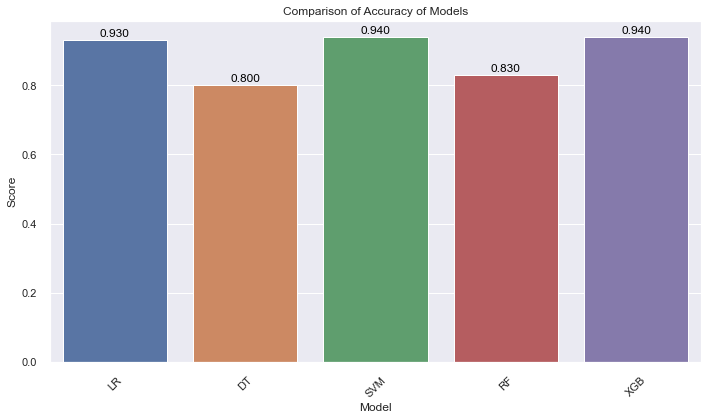

In [183]:
import seaborn as sns
score = F1_scores.values()
model = F1_scores.keys()
comparision = pd.DataFrame(data={"Model": model, "Scores": score})
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Scores", data=comparision, errwidth=0.1)
for index, row in comparision.iterrows():
    ax.text(row.name, row.Scores + 0.01, f"{row.Scores:.3f}", color='black', ha='center')
plt.title("Comparison of Accuracy of Models")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Hyper Tuning

### 3.1 Logistic Regression

In [110]:

logistic_hyp = LogisticRegression(penalty='l2', solver='saga', C=2.0)


In [111]:
logistic_hyp.fit(X_train,Y_train)

C:\Users\prane\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=2.0, solver='saga')

Training Accuracy: 0.9325513440752735
Testing Accuracy: 0.9164075741663114

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.96      0.93      0.94     64168
  defacement       0.96      0.99      0.97     14353
     malware       0.82      0.95      0.88      3511
    phishing       0.72      0.79      0.75     14137

    accuracy                           0.92     96169
   macro avg       0.86      0.91      0.89     96169
weighted avg       0.92      0.92      0.92     96169


CONFUSION MATRIX


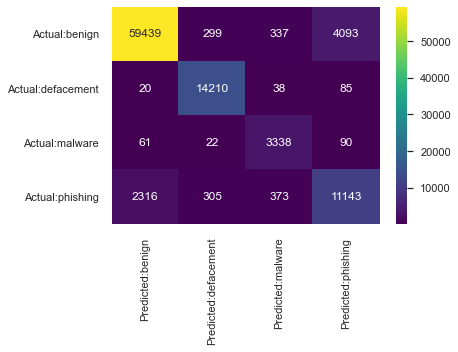

In [112]:
training_accuracy = accuracy_score(Y_train, logistic_hyp.predict(X_train))
testing_accuracy = accuracy_score(Y_test, logistic_hyp.predict(X_test))
print('Testing Accuracy:', test_accuracy)
print('Training Accuracy:', train_accuracy)
pred_lgr = logistic_hyp.predict(X_test)
con_m = pd.crosstab(Y_test, pred_lgr, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
report = classification_report(Y_test, pred_lgr)
print(report)
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d',cmap='viridis')
plt.show()


In [114]:

f1_score_pred_lgr = f1_score(Y_test, pred_lgr, average='macro', labels=np.unique(pred_lgr))
print(f1_score_pred_lgr)
hyper_tunning = {}
hyper_tunning['LR'] = np.round(f1_score_pred_lgr, 2)

0.8875247595374005


### 3.2 Decision Tree

In [127]:

destree_hyper = DecisionTreeClassifier(criterion='gini', max_depth=15, class_weight='balanced')



In [128]:
destree_hyper.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=15)

Training Accuracy: 0.8784018365252623
Testing Accuracy: 0.8881240316526116

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.95      0.91      0.93     64168
  defacement       0.94      0.95      0.94     14353
     malware       0.80      0.91      0.85      3511
    phishing       0.64      0.71      0.67     14137

    accuracy                           0.89     96169
   macro avg       0.83      0.87      0.85     96169
weighted avg       0.89      0.89      0.89     96169


CONFUSION MATRIX


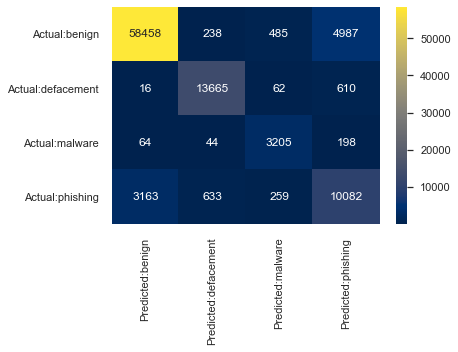

In [129]:
train_accuracy = accuracy_score(Y_train, destree_hyper.predict(X_train))
test_accuracy = accuracy_score(Y_test, destree_hyper.predict(X_test))
print('Training Accuracy:', train_accuracy)
print('Testing Accuracy:', test_accuracy)
pred_destree_hyper = destree_hyper.predict(X_test)
con_m = pd.crosstab(Y_test, pred_destree_hyper, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(Y_test, pred_destree_hyper))
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap="cividis")
plt.show()


In [130]:

f1_score_pred_destree_hyper = f1_score(Y_test, pred_destree_hyper, average='macro', labels=np.unique(pred_destree_hyper))
print(f1_score_pred_destree_hyper)

hyper_tunning['DT_hyper'] = np.round(f1_score_pred_destree_hyper, 2)

0.8493633556309617


### 3.3 Random Forest

In [131]:
from sklearn.ensemble import RandomForestClassifier

RandomF_hyper = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=7, n_jobs=-1)




In [132]:
RandomF_hyper.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, n_jobs=-1)

Training Accuracy: 0.7495551957138858
Testing Accuracy: 0.7433268516881739

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.90      0.77      0.83     64168
  defacement       0.88      0.72      0.79     14353
     malware       0.47      0.90      0.62      3511
    phishing       0.37      0.59      0.46     14137

    accuracy                           0.74     96169
   macro avg       0.65      0.75      0.67     96169
weighted avg       0.80      0.74      0.76     96169


CONFUSION MATRIX


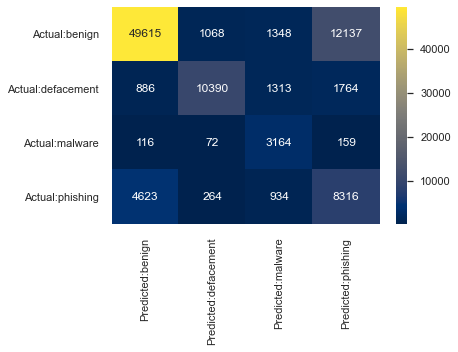

In [135]:
train_accuracy = accuracy_score(Y_train, RandomF_hyper.predict(X_train))
test_accuracy = accuracy_score(Y_test, RandomF_hyper.predict(X_test))
print('Training Accuracy:', train_accuracy)
print('Testing Accuracy:', test_accuracy)
pred_RandomF_hyper = RandomF_hyper.predict(X_test)
con_m = pd.crosstab(Y_test, pred_RandomF_hyper, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(Y_test, pred_RandomF_hyper))
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap="cividis")
plt.show()


In [136]:
f1_score_pred_randomf_hyper = f1_score(Y_test, pred_RandomF_hyper, average='macro', labels=np.unique(pred_RandomF_hyper))
print(f1_score_pred_randomf_hyper)

hyper_tunning['Randomf_hyper'] = np.round(f1_score_pred_randomf_hyper, 2)

0.6743565933349429


### 3.4 Support Vector Macine

In [138]:
from sklearn.svm import SVC
svm_hyper = SVC(kernel="linear", C=1.5, class_weight="balanced", decision_function_shape='ovo')



In [139]:
svm_hyper.fit(X_train,Y_train)

SVC(C=1.5, class_weight='balanced', decision_function_shape='ovo',
    kernel='linear')

Training Accuracy: 0.9980708488265163
Testing Accuracy: 0.94517983965727

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      benign       0.95      0.97      0.96     64168
  defacement       0.98      1.00      0.99     14353
     malware       0.96      0.94      0.95      3511
    phishing       0.86      0.77      0.81     14137

    accuracy                           0.95     96169
   macro avg       0.94      0.92      0.93     96169
weighted avg       0.94      0.95      0.94     96169


CONFUSION MATRIX


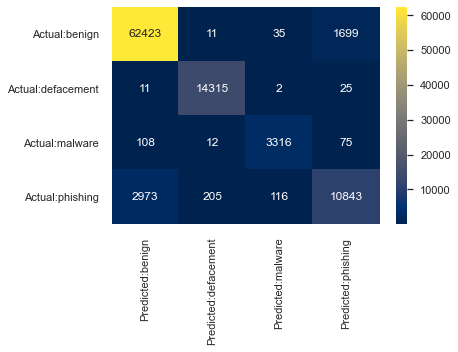

In [141]:
train_accuracy = accuracy_score(Y_train, svm_hyper.predict(X_train))
test_accuracy = accuracy_score(Y_test, svm_hyper.predict(X_test))
print('Training Accuracy:', train_accuracy)
print('Testing Accuracy:', test_accuracy)
pred_svm_hyper = svm_hyper.predict(X_test)
con_m = pd.crosstab(Y_test, pred_svm_hyper, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(Y_test, pred_svm_hyper))
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_m, annot=True, fmt='d', cmap="cividis")
plt.show()


In [142]:
f1_score_pred_svm_hyper = f1_score(Y_test, pred_svm_hyper, average='macro', labels=np.unique(pred_svm_hyper))
print(f1_score_pred_svm_hyper)

hyper_tunning['svm_hyper'] = np.round(f1_score_pred_svm_hyper, 2)

0.9283632141152248


In [143]:
hyper_tunning

{'LR': 0.89, 'DT_hyper': 0.85, 'Randomf_hyper': 0.67, 'svm_hyper': 0.93}

### 3.5 XGB

In [30]:
from xgboost import XGBClassifier
xgb_hp = XGBClassifier(n_estimators=1500,objective='binary:logistic',learning_rate=1.0,max_depth=15,min_child_weight=4)

In [31]:
xgb_hp.fit(X_train,Y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=1500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Training Accuracy : 0.9745478656058001
Testing Accuracy : 0.9225010138402188

CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     59389
           1       0.99      0.99      0.99     14458
           2       0.95      0.98      0.96      3396
           3       0.91      0.68      0.78     18926

    accuracy                           0.92     96169
   macro avg       0.94      0.91      0.92     96169
weighted avg       0.92      0.92      0.92     96169


CONFUSION MATRIX


<AxesSubplot:>

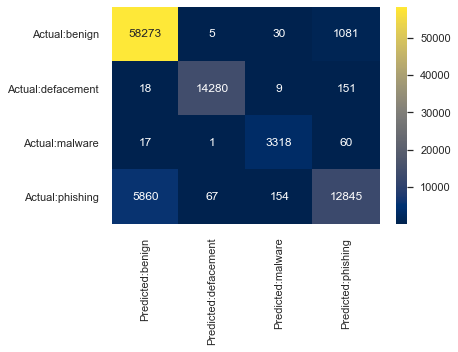

In [35]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
train_accuracy = accuracy_score(Y_train1, svm_hyper.predict(X_train))
test_accuracy = accuracy_score(Y_test1, svm_hyper.predict(X_test))
pred_xgb_hp=xgb_hp.predict(X_test)
con_m = pd.crosstab(Y_test, pred_xgb_hp, rownames=['Actual'], colnames=['Predicted'])
print('\nCLASSIFICATION REPORT\n')
print(classification_report(pred_xgb_hp, Y_test1))
print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_m, annot = True,fmt='d',cmap="cividis")

In [197]:
f1_score_xgb_hyper = f1_score(Y_test1, pred_xgb_hp, average='macro', labels=np.unique(pred_xgb_hp))
print(f1_score_xgb_hyper)


0.9180777329799765


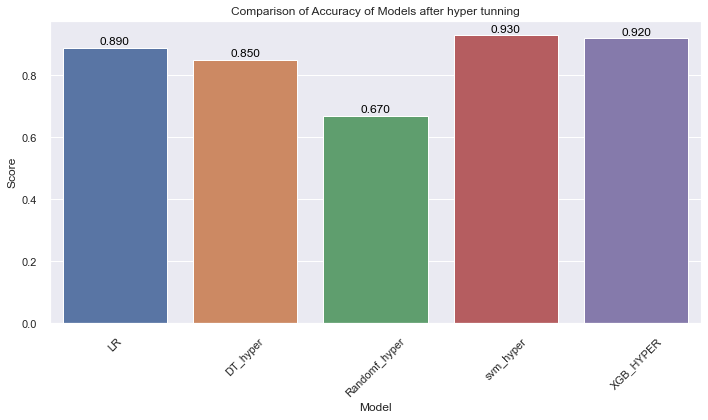

In [195]:
import seaborn as sns
score2 = hyper_tunning.values()
model2 = hyper_tunning.keys()
comp = pd.DataFrame(data={"Model": model2, "Scores": score2})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Scores", data=comp, errwidth=0.1)

for index, row in comp.iterrows():
    ax.text(row.name, row.Scores + 0.01, f"{row.Scores:.3f}", color='black', ha='center')

plt.title("Comparison of Accuracy of Models after hyper tunning")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4.CrossValidation

 ### 4.1 Logistic Regression

In [53]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv = CountVectorizer()
x = cv.fit_transform(data["text_sentance"])
y = data.type
model1 = LogisticRegression()
scores1 = cross_val_score(model1, x, y, cv=kf)
average_score1 = scores1.mean()
cv_scores = {'LR': average_score1}
print("Cross Validation Scores are {}".format(scores1))
print("Average Cross Validation score :{}".format(average_score1))
print("CV Scores Dictionary:", cv_scores)


C:\Users\prane\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\prane\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross Validation Scores are [0.93771934 0.93865519 0.94511168 0.9456264  0.94444098]
Average Cross Validation score :0.9423107175738513
CV Scores Dictionary: {'LR': 0.9423107175738513}


### 4.2 Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model2=DecisionTreeClassifier()
score2=cross_val_score(model2,x,y,cv=kf)
print("Cross Validation Scores are {}".format(score2))
average_score2 = sum(score2) / len(score2)
print("Average Cross Validation score :{}".format(average_score2))
average_score5

Cross Validation Scores are [0.88975715 0.89105174 0.89239144 0.89246943 0.89047292]


NameError: name 'scores5' is not defined

In [69]:
average_score2 = sum(score2) / len(score2)
print("Average Cross Validation score :{}".format(average_score2))
average_score2

Average Cross Validation score :0.8912285350359237


0.8912285350359237

### 4.3 SVM

In [70]:
from sklearn.svm import SVC
model3 = SVC()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores3 = cross_val_score(model3, x, y, cv=kf)
print("Cross Validation Scores are {}".format(scores3))
average_score3 = sum(scores3) / len(scores3)
print("Average Cross Validation score: {}".format(average_score3))
average_score3

Cross Validation Scores are [0.95133592 0.95071202 0.95233342 0.95231782 0.95214624]
Average Cross Validation score: 0.9517690852010651


0.9517690852010651

### 4.4 RandomForest

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
model4 = RandomForestClassifier(n_estimators=100)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores4 = cross_val_score(model4, x, y, cv=kf)
average_score4 = sum(scores4) / len(scores4)
print("Cross Validation Scores are {}".format(scores4))
print("Average Cross Validation score: {}".format(average_score4))

Cross Validation Scores are [0.95359755 0.95476736 0.95601447 0.95592089 0.95542176]
Average Cross Validation score: 0.9551444086445027


### 4.5 XGB

In [189]:
from sklearn.model_selection import KFold, cross_val_score

In [190]:
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
data1 = np.asarray(y)
model5 = XGBClassifier()
encoder = OrdinalEncoder()
y_encoded = encoder.fit_transform(data1.reshape(-1, 1))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores5 = cross_val_score(model5, x, y_encoded, cv=kf)
print("Cross Validation Scores are {}".format(scores5))
average_score5 = scores5.mean()
print("Average Cross Validation score: {}".format(average_score5))



Cross Validation Scores are [0.95847956 0.95798044 0.95927439 0.95938358 0.95971113]
Average Cross Validation score: 0.958965820875966


In [74]:
average_score2

0.9517690852010651

In [75]:

cv_scores['RF']=average_score4

In [77]:
cv_scores['SVM']=average_score3

In [78]:
cv_scores['DT']=average_score2

In [79]:
cv_scores

{'LR': 0.9423107175738513,
 'RF': 0.9551444086445027,
 'SVM': 0.9517690852010651,
 'DT': 0.8912285350359237}

In [191]:
cv_scores['XGB']=average_score5

### 4.6 Comparisons of Cross Validation Scores

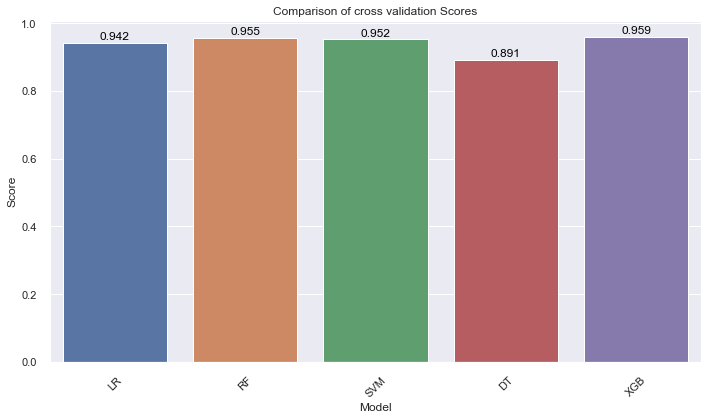

In [192]:
import seaborn as sns
scores = cv_scores.values()
models = cv_scores.keys()
comparisions = pd.DataFrame(data={"Model": models, "Scores": scores})
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Model", y="Scores", data=comparisions, errwidth=0.1)
for index, row in comparisions.iterrows():
    ax.text(row.name, row.Scores + 0.01, f"{row.Scores:.3f}", color='black', ha='center')
plt.title("Comparison of cross validation Scores")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
